In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

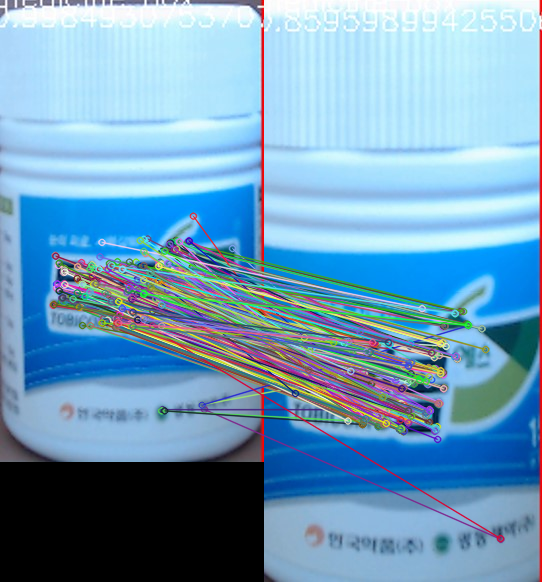

In [ ]:
# FLANNMatcher와 ORB로 매칭 (match_flann_orb.py)

import cv2, numpy as np

img1 = cv2.imread('query.jpg')
img2 = cv2.imread('test.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# ORB 추출기 생성
detector = cv2.ORB_create()
# 키 포인트와 서술자 추출
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)

# 인덱스 파라미터 설정 ---①
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6,
                   key_size = 12,
                   multi_probe_level = 1)
# 검색 파라미터 설정 ---②
search_params=dict(checks=32)
# Flann 매처 생성 ---③
matcher = cv2.FlannBasedMatcher(index_params, search_params)
# 매칭 계산 ---④
matches = matcher.match(desc1, desc2)
# 매칭 그리기
res = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, \
            flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
# 결과 출력      
from google.colab.patches import cv2_imshow      
cv2_imshow(res)
cv2.waitKey()
cv2.destroyAllWindows()

matches:122/485


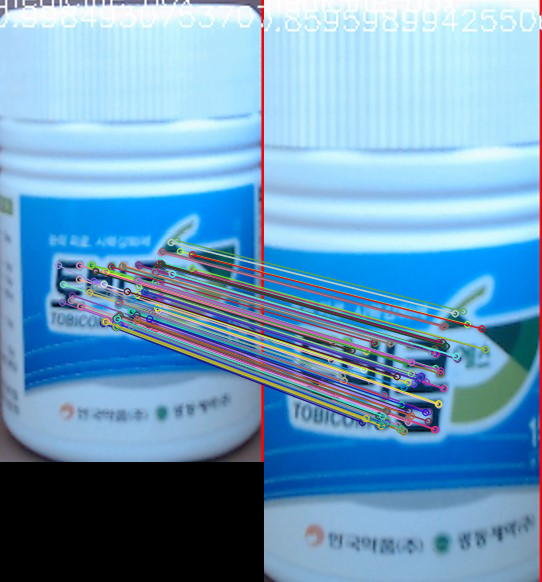

In [ ]:
# knnMatch 함수로부터 올바른 매칭점 찾기 (match_good_knn.py)

import cv2, numpy as np

img1 = cv2.imread('query.jpg')
img2 = cv2.imread('test.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# ORB로 서술자 추출 ---①
detector = cv2.ORB_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)
# BF-Hamming 생성 ---②
matcher = cv2.BFMatcher(cv2.NORM_HAMMING2)
# knnMatch, k=2 ---③
matches = matcher.knnMatch(desc1, desc2, 2)

# 첫번재 이웃의 거리가 두 번째 이웃 거리의 75% 이내인 것만 추출---⑤
ratio = 0.75
good_matches = [first for first,second in matches \
                    if first.distance < second.distance * ratio]
print('matches:%d/%d' %(len(good_matches),len(matches)))

# 좋은 매칭만 그리기
res = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, \
                    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
# 결과 출력                    
from google.colab.patches import cv2_imshow      
cv2_imshow(res)
cv2.waitKey()
cv2.destroyAllWindows()

good matches:26/485


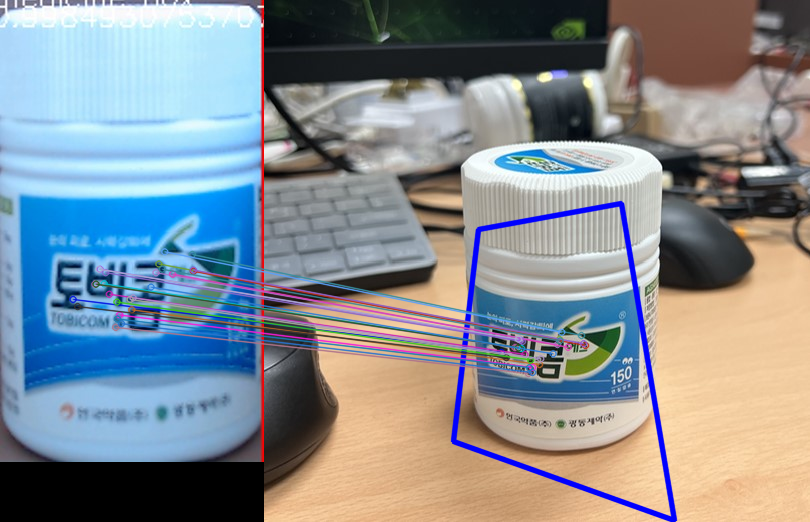

In [ ]:
import cv2, numpy as np

img1 = cv2.imread('query.jpg')
img2 = cv2.imread('tobicom.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# ORB, BF-Hamming 로 knnMatch  ---①
detector = cv2.ORB_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)
matcher = cv2.BFMatcher(cv2.NORM_HAMMING2)
matches = matcher.knnMatch(desc1, desc2, 2)

# 이웃 거리의 75%로 좋은 매칭점 추출---②
ratio = 0.75
good_matches = [first for first,second in matches \
                    if first.distance < second.distance * ratio]
print('good matches:%d/%d' %(len(good_matches),len(matches)))

# 좋은 매칭점의 queryIdx로 원본 영상의 좌표 구하기 ---③
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ])
# 좋은 매칭점의 trainIdx로 대상 영상의 좌표 구하기 ---④
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ])
# 원근 변환 행렬 구하기 ---⑤
mtrx, mask = cv2.findHomography(src_pts, dst_pts)
# 원본 영상 크기로 변환 영역 좌표 생성 ---⑥
h,w, = img1.shape[:2]
pts = np.float32([ [[0,0]],[[0,h-1]],[[w-1,h-1]],[[w-1,0]] ])
# 원본 영상 좌표를 원근 변환  ---⑦
dst = cv2.perspectiveTransform(pts,mtrx)
# 변환 좌표 영역을 대상 영상에 그리기 ---⑧
img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

# 좋은 매칭 그려서 출력 ---⑨
res = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, \
                    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
from google.colab.patches import cv2_imshow      
cv2_imshow(res)
cv2.waitKey()
cv2.destroyAllWindows()

accuracy: 15/151(0.10%)


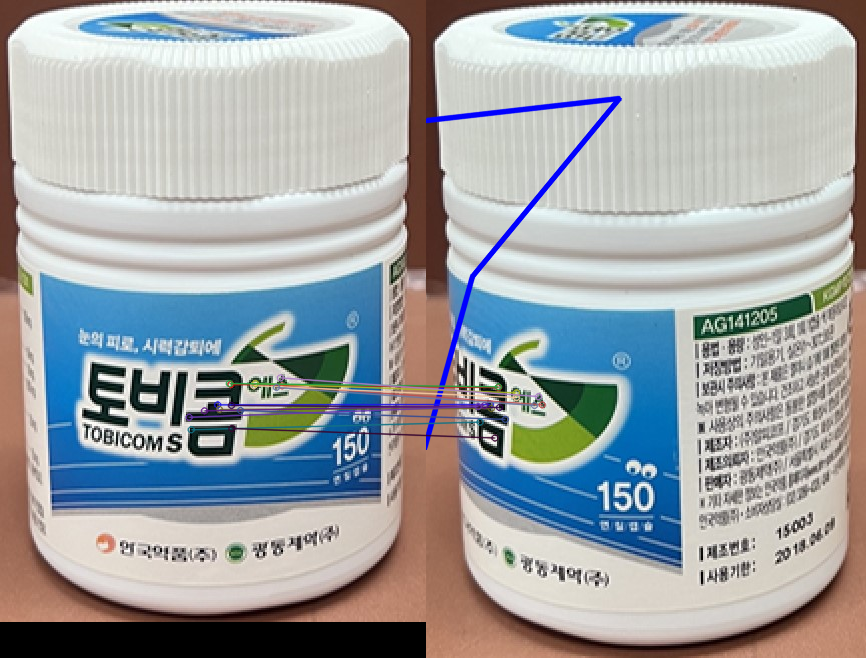

In [28]:
import cv2, numpy as np

img1 = cv2.imread('img1.jpg')
img2 = cv2.imread('img2.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# ORB, BF-Hamming 로 knnMatch  ---①
detector = cv2.ORB_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = matcher.match(desc1, desc2)

# 매칭 결과를 거리기준 오름차순으로 정렬 ---③
matches = sorted(matches, key=lambda x:x.distance)
# 모든 매칭점 그리기 ---④
res1 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, \
                    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

# 매칭점으로 원근 변환 및 영역 표시 ---⑤
src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ])
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ])
# RANSAC으로 변환 행렬 근사 계산 ---⑥
mtrx, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
h,w = img1.shape[:2]
pts = np.float32([ [[0,0]],[[0,h-1]],[[w-1,h-1]],[[w-1,0]] ])
dst = cv2.perspectiveTransform(pts,mtrx)
img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

# 정상치 매칭만 그리기 ---⑦
matchesMask = mask.ravel().tolist()
res2 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, \
                    matchesMask = matchesMask,
                    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
# 모든 매칭점과 정상치 비율 ---⑧
accuracy=float(mask.sum()) / mask.size
print("accuracy: %d/%d(%.2f%%)"% (mask.sum(), mask.size, accuracy))

# 결과 출력                    
from google.colab.patches import cv2_imshow      

cv2_imshow(res2)
cv2.waitKey()
cv2.destroyAllWindows()

img1:(201.60000610351562, 549.6000366210938) - img2:(190.8000030517578, 483.6000061035156)
img1:(98.0, 390.0) - img2:(282.0, 319.0)
img1:(217.20001220703125, 404.4000244140625) - img2:(57.60000228881836, 429.6000061035156)
img1:(281.6640319824219, 385.3440246582031) - img2:(76.0320053100586, 432.0000305175781)
img1:(93.0, 364.0) - img2:(169.0, 583.0)
img1:(96.0, 393.0) - img2:(53.0, 373.0)
img1:(163.0, 413.0) - img2:(218.0, 505.0)
img1:(230.40000915527344, 384.0) - img2:(90.0, 394.8000183105469)
img1:(160.8000030517578, 549.6000366210938) - img2:(45.60000228881836, 422.4000244140625)
img1:(168.0, 372.0) - img2:(205.20001220703125, 468.0000305175781)
img1:(142.8000030517578, 438.0000305175781) - img2:(369.6000061035156, 525.6000366210938)
img1:(98.0, 379.0) - img2:(208.0, 470.0)
img1:(253.20001220703125, 385.20001220703125) - img2:(73.20000457763672, 364.8000183105469)
img1:(254.8800048828125, 383.0400085449219) - img2:(135.36000061035156, 578.8800048828125)
img1:(104.4000015258789, 440

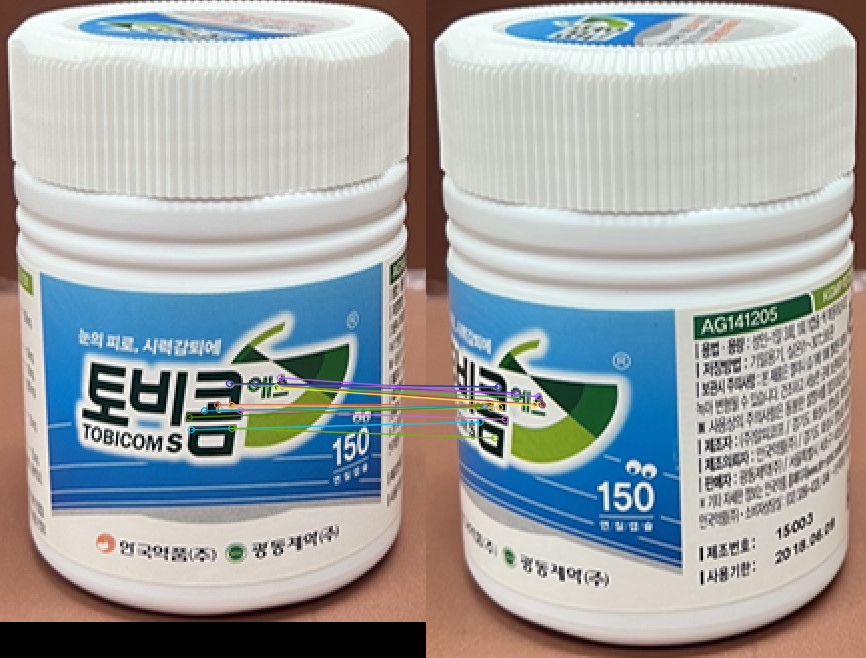

In [16]:
import cv2, numpy as np

img1 = cv2.imread('img1.jpg')
img2 = cv2.imread('img2.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# ORB, BF-Hamming 로 knnMatch  ---①
detector = cv2.ORB_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = matcher.match(desc1, desc2)

# 매칭 결과를 거리기준 오름차순으로 정렬 ---③
matches = sorted(matches, key=lambda x:x.distance)
for match in matches:
    print(f"img1:{kp1[match.queryIdx].pt} - img2:{kp2[match.queryIdx].pt}")
    
# 모든 매칭점 그리기 ---④
res1 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, \
                    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

# 매칭점으로 원근 변환 및 영역 표시 ---⑤
src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ])
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ])

# RANSAC으로 변환 행렬 근사 계산 ---⑥
mtrx, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

h,w = img1.shape[:2]
pts = np.float32([ [[0,0]],[[0,h-1]],[[w-1,h-1]],[[w-1,0]] ])
dst = cv2.perspectiveTransform(pts,mtrx)
#img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

# 정상치 매칭만 그리기 ---⑦
matchesMask = mask.ravel().tolist()
res2 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, \
                    matchesMask = matchesMask,
                    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
# 모든 매칭점과 정상치 비율 ---⑧
accuracy=float(mask.sum()) / mask.size
print("accuracy: %d/%d(%.2f%%)"% (mask.sum(), mask.size, accuracy))

warped_image = cv2.warpPerspective(img1, mtrx, (img2.shape[1], img2.shape[0]))
cv2.imwrite("test.jpg", warped_image)
# 결과 출력                    
from google.colab.patches import cv2_imshow      

cv2_imshow(res2)
cv2.waitKey()
cv2.destroyAllWindows()

[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
img1:(217.20001220703125, 404.4000244140625) - img2:(57.60000228881836, 429.6000061035156)
img1:(281.6640319824219, 385.3440246582031) - img2:(76.0320053100586, 432.0000305175781)
img1:(230.40000915527344, 384.0) - img2:(90.0, 394.8000183105469)
img1:(253.20001220703125, 385.20001220703125) - img2:(73.20000457763672, 364.8000183105469)
img1:(254.8800048828125, 383.0400085449219) - img2:(135.36000061035156, 578.8800048828125)
img1:(218.8800048828125, 408.96002197265625) - img2:(217.44000244140625, 488.1600341796875)
img1:(228.9600067138672, 

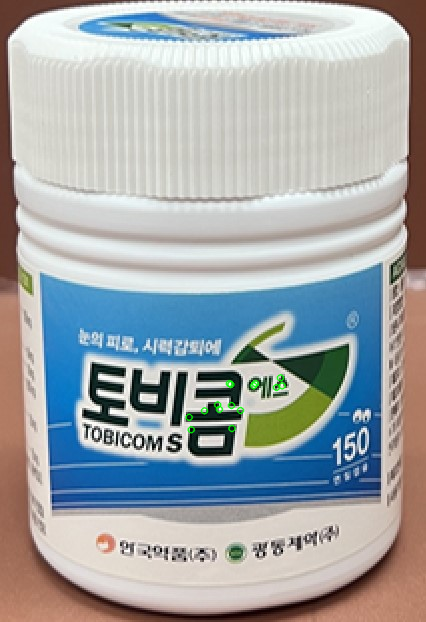

In [43]:
print(matchesMask)

kp1_list = []
kp2_list = []
i = 0
while i < len(matchesMask):
    if matchesMask[i] == 1:
        print(f"img1:{kp1[matches[i].queryIdx].pt} - img2:{kp2[matches[i].queryIdx].pt}")
        kp1_list.append(kp1[matches[i].queryIdx])
        kp2_list.append(kp2[matches[i].queryIdx])
    i = i + 1

result1 = cv2.drawKeypoints(img1, kp1_list, img2, (0,255,0), flags = 0)
result2 = cv2.drawKeypoints(img2, kp2_list, img1, (0,255,0), flags = 0)
from google.colab.patches import cv2_imshow      

cv2_imshow(result1)
cv2.waitKey()
cv2.destroyAllWindows()


[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
img1:(217.20001220703125, 404.4000244140625) - img2:(64.0, 404.0)
img1:(281.6640319824219, 385.3440246582031) - img2:(115.77600860595703, 404.35205078125)
img1:(230.40000915527344, 384.0) - img2:(72.0, 387.0)
img1:(253.20001220703125, 385.20001220703125) - img2:(90.0, 397.0)
img1:(254.8800048828125, 383.0400085449219) - img2:(90.0, 392.4000244140625)
img1:(218.8800048828125, 408.96002197265625) - img2:(64.80000305175781, 408.0000305175781)
img1:(228.9600067138672, 383.0400085449219) - img2:(72.0, 386.4000244140625)
img1:(231.0, 405.0) - img

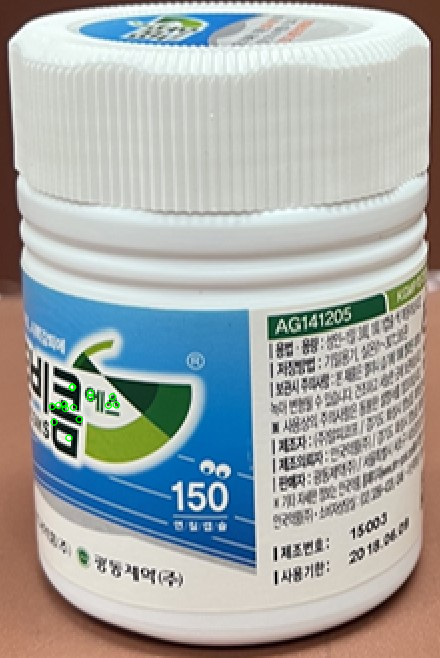

In [49]:
print(matchesMask)

kp1_list = []
kp2_list = []
i = 0
while i < len(matchesMask):
    if matchesMask[i] == 1:
        print(f"img1:{kp1[matches[i].queryIdx].pt} - img2:{kp2[matches[i].trainIdx].pt}")
        kp1_list.append(kp1[matches[i].queryIdx])
        kp2_list.append(kp2[matches[i].trainIdx])
    i = i + 1

result1 = cv2.drawKeypoints(img1, kp1_list, img2, (0,255,0), flags = 0)
result2 = cv2.drawKeypoints(img2, kp2_list, img1, (0,255,0), flags = 0)
from google.colab.patches import cv2_imshow      

cv2_imshow(result2)
cv2.waitKey()
cv2.destroyAllWindows()

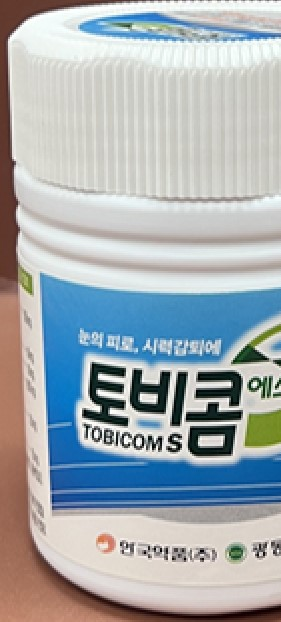

In [48]:
img1 = cv2.imread('img1.jpg')
img2 = cv2.imread('img2.jpg')

h1,w1,c1 = img1.shape
h2,w2,c2 = img2.shape
roi1 = img1[0:h1,0:281]
roi2 = img2[0:h2,0:282]

from google.colab.patches import cv2_imshow      

cv2_imshow(roi1)
cv2.waitKey()
cv2.destroyAllWindows()

In [53]:
print(type(kp1_list[0].pt))

<class 'tuple'>


AttributeError: ignored

In [55]:
kp1_tuple_list = []
kp2_tuple_list = []
for k in kp1_list:
  kp1_tuple_list.append(k.pt)
print(kp1_tuple_list)
for k in kp2_list:
  kp2_tuple_list.append(k.pt)
print(kp2_tuple_list)


[(217.20001220703125, 404.4000244140625), (281.6640319824219, 385.3440246582031), (230.40000915527344, 384.0), (253.20001220703125, 385.20001220703125), (254.8800048828125, 383.0400085449219), (218.8800048828125, 408.96002197265625), (228.9600067138672, 383.0400085449219), (231.0, 405.0), (204.00001525878906, 410.4000244140625), (276.0, 387.0), (240.0, 410.0), (279.93603515625, 377.395263671875), (190.77122497558594, 429.2352600097656), (188.6976318359375, 416.7936706542969), (231.413818359375, 427.99114990234375)]
[(64.0, 404.0), (115.77600860595703, 404.35205078125), (72.0, 387.0), (90.0, 397.0), (90.0, 392.4000244140625), (64.80000305175781, 408.0000305175781), (72.0, 386.4000244140625), (73.0, 407.0), (58.0, 405.0), (108.0, 405.0), (78.79681396484375, 418.86724853515625), (111.97441864013672, 396.0576477050781), (53.5680046081543, 421.6320495605469), (51.840003967285156, 406.08001708984375), (68.4288101196289, 437.5296630859375)]


In [57]:
import pandas as pd
df1 = pd.DataFrame(kp1_tuple_list, columns=['x','y'])
df2 = pd.DataFrame(kp2_tuple_list, columns=['x','y'])

print(df1)
print()
print(df2)

             x           y
0   217.200012  404.400024
1   281.664032  385.344025
2   230.400009  384.000000
3   253.200012  385.200012
4   254.880005  383.040009
5   218.880005  408.960022
6   228.960007  383.040009
7   231.000000  405.000000
8   204.000015  410.400024
9   276.000000  387.000000
10  240.000000  410.000000
11  279.936035  377.395264
12  190.771225  429.235260
13  188.697632  416.793671
14  231.413818  427.991150

             x           y
0    64.000000  404.000000
1   115.776009  404.352051
2    72.000000  387.000000
3    90.000000  397.000000
4    90.000000  392.400024
5    64.800003  408.000031
6    72.000000  386.400024
7    73.000000  407.000000
8    58.000000  405.000000
9   108.000000  405.000000
10   78.796814  418.867249
11  111.974419  396.057648
12   53.568005  421.632050
13   51.840004  406.080017
14   68.428810  437.529663


In [60]:
print(df1['x'].max())
print(df2['x'].max())


281.6640319824219
115.77600860595703
